In [49]:
import numpy as np
from astropy.io import fits
import os
import glob as glob
import pandas as pd
import dawis as d
import matplotlib.pyplot as plt
from matplotlib import colors, colorbar
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import matplotlib.image as mpimg
from astropy.visualization import *
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.offsetbox import AnchoredText
from scipy.ndimage import gaussian_filter
from scipy.ndimage import zoom
import pyregion as pyr
import cmasher
import matplotlib as mpl
import pyregion as pyr

In [50]:
# Paths, lists & variables
path_data = '/home/aellien/JWST/data/'
path_scripts = '/home/aellien/JWST/JWST_scripts'
path_wavelets = '/home/aellien/JWST/wavelets/out21/'
path_plots = '/home/aellien/JWST/plots'
path_analysis = '/home/ellien/JWST/analysis'

In [51]:
# concat dataframes
init = True
for nf in glob.glob( os.path.join(path_wavelets, '*fICL.txt')):
    if init:
        tot_df = pd.read_csv(nf, sep = ' ')
        init = False
    else:
        df = pd.read_csv(nf, sep = ' ')
        tot_df = pd.concat([ tot_df, df], axis = 0)
tot_df = tot_df.sort_values(by = 'name')

In [52]:
tot_df.keys()

Index(['Unnamed: 0', 'name', 'lvl_sep', 'size_sep', 'F_ICLBCG_m',
       'F_ICLBCG_low', 'F_ICLBCG_up', 'F_gal_m', 'F_gal_low', 'F_gal_up',
       'f_ICLBCG_m', 'f_ICLBCG_low', 'f_ICLBCG_up', 'F_128kpc_icl_m',
       'F_128kpc_icl_low', 'F_128kpc_icl_up', 'F_200kpc_icl_m',
       'F_200kpc_icl_low', 'F_200kpc_icl_up', 'F_400kpc_icl_m',
       'F_400kpc_icl_low', 'F_400kpc_icl_up', 'F_50_150kpc_icl_m',
       'F_50_150kpc_icl_low', 'F_50_150kpc_icl_up', 'F_128kpc_gal_m',
       'F_128kpc_gal_low', 'F_128kpc_gal_up', 'F_200kpc_gal_m',
       'F_200kpc_gal_low', 'F_200kpc_gal_up', 'F_400kpc_gal_m',
       'F_400kpc_gal_low', 'F_400kpc_gal_up', 'F_50_150kpc_gal_m',
       'F_50_150kpc_gal_low', 'F_50_150kpc_gal_up'],
      dtype='object')

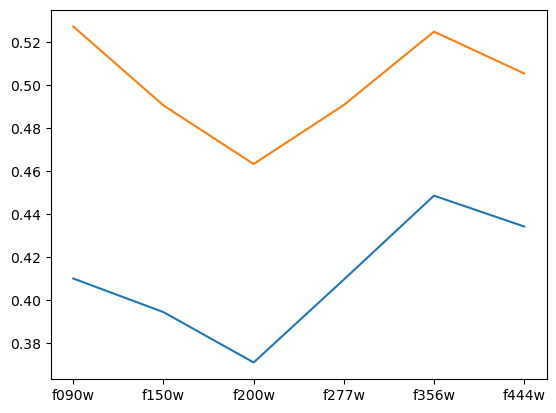

In [53]:
plt.figure()
filtl = [ name.split('_')[1] for name in tot_df['name']]
plt.plot(filtl, tot_df['f_ICLBCG_m'])

f50_150 = tot_df['F_50_150kpc_icl_m'] / ( tot_df['F_50_150kpc_gal_m'] + tot_df['F_50_150kpc_icl_m'])
plt.plot(filtl, f50_150)
plt.show()

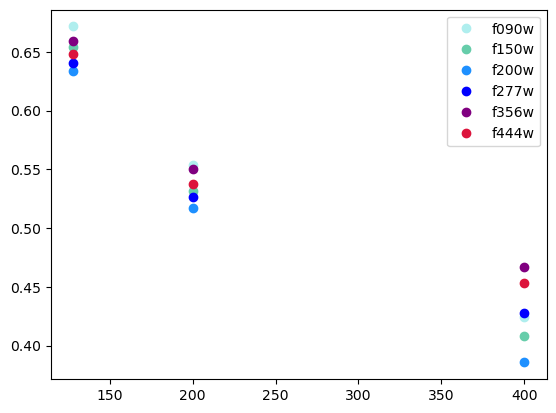

In [71]:
plt.figure()
rl = [128, 200, 400]
colors = [ 'paleturquoise', 'mediumaquamarine', 'dodgerblue', 'blue', 'purple', 'crimson']
for r in rl:
    fICL =  tot_df['F_%03dkpc_icl_m'%r] / ( (tot_df['F_%03dkpc_icl_m'%r] + tot_df['F_%03dkpc_gal_m'%r]))
    for f, filt, color in zip(fICL, filtl, colors):
        if r == 128:
            plt.plot(r, f, 'o', color = color, label = filt)
        else:
            plt.plot(r, f, 'o', color = color)
plt.legend()
plt.show()